# Goal
Methods to select the right number of 'k' for KMeans clustering.  
  
These methods although visual, are more feasible for larger datasets because the amount of data rendered in a plot in not very much. Scatterplots where every raw data point is rendered to see the visual spread of a cluster (relative to the centroid and relative to other clusters) involves rendering all the raw data points which is not 
practical for big data.

1. Visual Elbow Criterion method
2. Silhouette Analysis method

In [1]:
# PYTHON MODULES

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import findspark
findspark.init()

import pyspark;
import os;

In [16]:
# PYSPARK MODULES

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as f

from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator

In [4]:
spark = SparkSession.builder.master('local').appName('kmeans').config('spark.driver.memory', '5G').getOrCreate()

In [5]:
spark.builder.config('spark.executor.memory', '16G')
spark.builder.config("spark.executor.cores", "4")

### Data
The iris dataset is only to make sure the reader's focus is on the technique and not the data.  
**Note: When using your data, please make sure you have transformed and assembled (Vector assembler) the data so that the assumptions of KMeans have been considered.**

In [8]:
df = spark.read.csv("../input_data/iris.csv", header=True, inferSchema=True)
df.show(5)

+---+-----------+----------+-----------+----------+-------+
| Id|SepalLength|SepalWidth|PetalLength|PetalWidth|Species|
+---+-----------+----------+-----------+----------+-------+
|  1|        5.1|       3.5|        1.4|       0.2| setosa|
|  2|        4.9|       3.0|        1.4|       0.2| setosa|
|  3|        4.7|       3.2|        1.3|       0.2| setosa|
|  4|        4.6|       3.1|        1.5|       0.2| setosa|
|  5|        5.0|       3.6|        1.4|       0.2| setosa|
+---+-----------+----------+-----------+----------+-------+
only showing top 5 rows



In [12]:
df.describe().show()

+-------+------------------+------------------+-------------------+------------------+------------------+---------+
|summary|                Id|       SepalLength|         SepalWidth|       PetalLength|        PetalWidth|  Species|
+-------+------------------+------------------+-------------------+------------------+------------------+---------+
|  count|               150|               150|                150|               150|               150|      150|
|   mean|              75.5| 5.843333333333335|  3.057333333333334|3.7580000000000027| 1.199333333333334|     null|
| stddev|43.445367992456916|0.8280661279778637|0.43586628493669793|1.7652982332594662|0.7622376689603467|     null|
|    min|                 1|               4.3|                2.0|               1.0|               0.1|   setosa|
|    max|               150|               7.9|                4.4|               6.9|               2.5|virginica|
+-------+------------------+------------------+-------------------+-----

#### Log transformations

In [17]:
num_columns = [col[0] for col in df.dtypes if col[1] != 'string']
log_transformed_df = df.select([ f.log10 
                                    (
                                        f.col(colm) + 1
                                    ).name(colm)    
                                for colm in num_columns ])

#### Assembling and scaling

In [18]:
# The columns need to be assembled into a single feature column before standard scaling them 
assembler = VectorAssembler( inputCols = log_transformed_df.columns, outputCol = 'unscaled_features' )

scaler = StandardScaler( inputCol = 'unscaled_features', outputCol = 'features', withMean = True, withStd = True )

sca_pipeline = Pipeline(stages= [assembler, scaler])

In [19]:
scaled_df = sca_pipeline.fit(log_transformed_df).transform(log_transformed_df)

#### 1. The Elbow criterion

In [24]:
max_k = 8

In [25]:
ss = {} # this python dict will store the sum of sqares of each KMeans run
for k in range(2, max_k+1, 1):
    kmeans = KMeans(k= k, seed=1, featuresCol='features', predictionCol='prediction') # these need to be the column names or else PySpark Barks!!
    k_model = kmeans.fit(scaled_df)
    
    ss[k] = k_model.computeCost(scaled_df)
    print('Completed Kmeans with {} clusters'.format(k))

Completed Kmeans with 2 clusters
Completed Kmeans with 3 clusters
Completed Kmeans with 4 clusters
Completed Kmeans with 5 clusters
Completed Kmeans with 6 clusters
Completed Kmeans with 7 clusters
Completed Kmeans with 8 clusters


Lets visualize this using a pointplot and look for the cluster number where the decrease is steep. The idea is to use this as an estimate and experiment with some k values above and below this. 

Text(0, 0.5, 'Sum of Squared Distance')

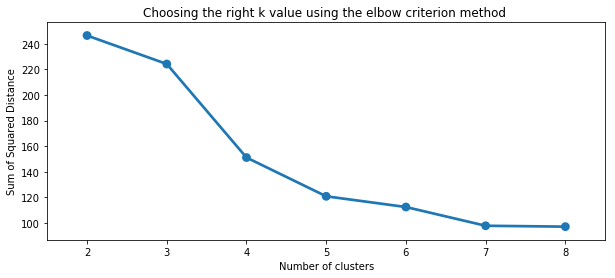

In [34]:
plt.figure(figsize=(10, 4))

sns.pointplot(x=list(ss.keys()), y=list(ss.values()))
plt.title('Choosing the right k value using the elbow criterion method ')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distance')

#### 2. Silhouette Score criterion

In [31]:
sil_sc = {}
for i in range(2, max_k+1, 1):
    kmeans = KMeans(k=i, seed=1, featuresCol='features', predictionCol='prediction' )
    k_pred = kmeans.fit(scaled_df).transform(scaled_df)
    
    ev = ClusteringEvaluator()
    sil_sc[i] = ev.evaluate(k_pred)
    print("Completed KMeans with {} clusters".format(i))

Completed KMeans with 2 clusters
Completed KMeans with 3 clusters
Completed KMeans with 4 clusters
Completed KMeans with 5 clusters
Completed KMeans with 6 clusters
Completed KMeans with 7 clusters
Completed KMeans with 8 clusters


In [32]:
sil_sc

{2: 0.8136440608004682,
 3: 0.659587091910402,
 4: 0.5611508789301319,
 5: 0.5031851153209905,
 6: 0.4025703638375273,
 7: 0.46512469202751733,
 8: 0.4748332659176899}

In [35]:
spark.stop()